# The Sims-Flanagan high-fidelity trajectory leg

The Sims-Flanagan trajectory leg {cite:p}`sims` is implemented in `pykep` in the class {class}`pykep.leg.sims_flanagan_hf`. The leg can be used to describe a low-thrust leg with low-fidelity as it assumes Keplerian dynamics
and approximates the continuous thrust via a sequence of continuous, constant thrust arcs (zero-hold). The leg is defined by a starting position $\mathbf x_s = [\mathbf r_s, \mathbf v_s, m_s]$, an arrival position $\mathbf x_f = [\mathbf r_f, \mathbf v_f, m_f]$ and a time of flight $T$.

A sequence of throttles $\mathbf u = [u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, u_{x2}, u_{y2}, u_{z2}, ... ]$ define the direction and magnitude of the continuous throttle vector along each segment (i.e. trajectory parts of equal temporal length $\frac Tn$).

In this tutorial we show the basic API to interface with the class {class}`pykep.leg.sims_flanagan_hf` efficiently.

We start with some imports:

In [1]:
import pykep as pk
import numpy as np
import time
import pygmo as pg

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline

We then define the spacecraft propulsion system and the initial and final state. In this case they are not related to any orbital mechanics and are chosen arbitrarily for the purpose of demostrating the API.

In [2]:
# Problem data
mu = pk.MU_SUN
max_thrust = 0.12
isp = 3000

# Initial state
ms = 1500.0
rs = np.array([1, 0.1, -0.1]) * pk.AU
vs = np.array([0.2, 1, -0.2]) * pk.EARTH_VELOCITY

# Final state
mf = 1300.0
rf = np.array([-1.2, -0.1, 0.1]) * pk.AU
vf = np.array([0.2, -1.023, 0.44]) * pk.EARTH_VELOCITY

# Throttles and tof
nseg = 10
cut = 0.6
throttles = np.random.uniform(-1, 1, size=(nseg * 3))
tof = 324.0 * pk.DAY2SEC

Now we instantiate the leg:

In [3]:
# We are now ready to instantiate a leg
sf = pk.leg.sims_flanagan_hf(
    rvs=[rs, vs],
    ms=ms,
    throttles=throttles,
    rvf=[rf, vf],
    mf=mf,
    tof=tof,
    max_thrust=max_thrust,
    veff=isp * pk.G0,
    mu=mu,
    cut=cut,
)

And plot the trajectory represented by the random sequence of throttles.

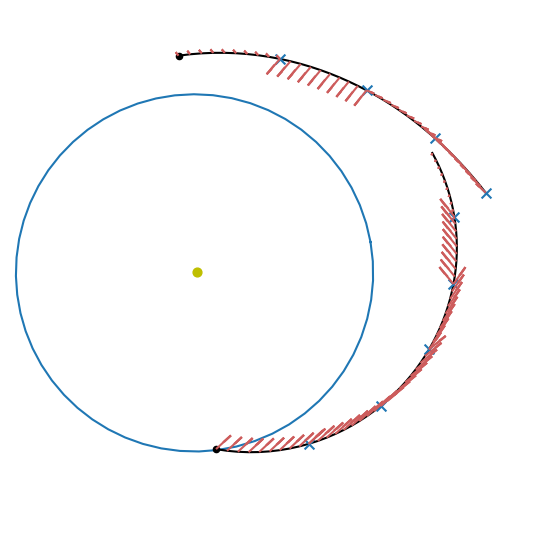

In [4]:
# Making the axis
ax = pk.plot.make_3Daxis(figsize=(7, 7))

# Adding the Sun Earth and the boundary states
udpla = pk.udpla.jpl_lp(body="EARTH")
earth = pk.planet(udpla)
pk.plot.add_sun(ax, s=40)
pk.plot.add_planet_orbit(ax, earth)
ax.scatter(rs[0] / pk.AU, rs[1] / pk.AU, rs[2] / pk.AU, c="k", s=20)
ax.scatter(rf[0] / pk.AU, rf[1] / pk.AU, rf[2] / pk.AU, c="k", s=20)


# Plotting the trajctory leg
ax = pk.plot.add_sf_hf_leg(
    ax, sf, units=pk.AU, N=10, show_gridpoints=True, show_throttles=True, length=0.1, arrow_length_ratio=0.5
)


# Making the axis nicer
D=1
ax.set_xlim(-D,D)
ax.set_ylim(-D/2,D*3/2)
ax.view_init(90,0)
ax.axis('off');


# The gradients
The main function of this leg is to serve as a fwd-bck shooting blosk in larger optimization problems. The efficent autodiff computation of the gradients of the mismatch and throttle constraints are thus provided for convenience. Indicating the mismatch constraints with $\mathbf{mc}$ and the throttle constraints with $\mathbf{tc}$ we seek the following quntities:

$$
  \frac{\partial \mathbf {mc}}{\partial \mathbf x_s} \rightarrow (7\times7)
$$

$$
  \frac{\partial \mathbf {mc}}{\partial \mathbf x_f} \rightarrow (7\times7)
$$

$$
  \frac{\partial \mathbf {mc}}{\partial \mathbf {\tilde u}} \rightarrow (7\times(3\mathbf{nseg} + 1))
$$

$$
\frac{\partial \mathbf {tc}}{\partial \mathbf u} \rightarrow (\mathbf{nseg} \times3\mathbf{nseg})
$$

where $\mathbf x_s=[\mathbf r, \mathbf v, m]$ is the starting state, $\mathbf x_f$ is the final state $\mathbf u=[u_0, u_1 ... u_{nseg}]$ are the throttles and $\mathbf {\tilde u}=[\mathbf u, tof]$ the trottles augmented with $tof$ .

In [5]:
dmcdxs, dmcdxf, dmcdu = sf.compute_mc_grad()
print("dmcdxs shape: ", dmcdu.shape)
print("dmcdxf shape: ", dmcdu.shape)
print("dmcdu shape: ", dmcdu.shape)
dtcdu = sf.compute_tc_grad()
print("dtcdu shape: ", dtcdu.shape)

dmcdxs shape:  (7, 31)
dmcdxf shape:  (7, 31)
dmcdu shape:  (7, 31)
dtcdu shape:  (10, 30)


# Gradient correctness
We check the gradient correctness against numerical differentiation.

### First the mismatch constraints

In [6]:
# These functions are to be used in an estimate_gradient_h call
def mc_from_rvms(sf, rvms):
    sf.rvms = rvms
    return sf.compute_mismatch_constraints()

def mc_from_rvmf(sf, rvmf):
    sf.rvmf = rvmf
    return sf.compute_mismatch_constraints()

def mc_from_utilda(sf, utilda):
    sf.throttles = utilda[:-1]
    sf.tof = utilda[-1]
    return sf.compute_mismatch_constraints()

In [7]:
# Reference values where to compute the numerical gradients
rvms = sf.rvms.copy()
rvmf = sf.rvmf.copy()
utilda = sf.throttles.copy() + [sf.tof]
# Numerical gradients
dmcdxs_numerical = pg.estimate_gradient_h(lambda x: mc_from_rvms(sf, x), rvms, 1e-6).reshape(7,7)
dmcdxf_numerical = pg.estimate_gradient_h(lambda x: mc_from_rvmf(sf, x), rvmf, 1e-6).reshape(7,7)
dmcdu_numerical = pg.estimate_gradient_h(lambda x: mc_from_utilda(sf, x), utilda, 1e-6).reshape(7, nseg*3 + 1)

We check against the analytical gradients that all went well.

In [9]:
print("Check gradient of mc wrt xs: ", np.allclose(dmcdxs_numerical, dmcdxs, rtol=1e-5, atol=1e-5))  # True
print("Check gradient of mc wrt xf: ", np.allclose(dmcdxf_numerical, dmcdxf, rtol=1e-5, atol=1e-5))  # True
print("Check gradient of mc wrt u:  ", np.allclose(dmcdu_numerical, dmcdu, rtol=1e-3, atol=1e-3))  # True

Check gradient of mc wrt xs:  True
Check gradient of mc wrt xf:  True
Check gradient of mc wrt u:   True


### Then the throttle constraints

In [10]:
def tc_from_u(sf, u):
    sf.throttles = u
    return sf.compute_throttle_constraints()

In [11]:
# Reference values where to compute the numerical gradients
u = sf.throttles.copy()
# Numerical gradient
dtcdu_numerical = pg.estimate_gradient_h(lambda x: tc_from_u(sf, x), u, 1e-6).reshape(nseg, nseg*3)


In [12]:
print("Check gradient of tc wrt u:  ", np.allclose(dtcdu_numerical, dtcdu, rtol=1e-5, atol=1e-5))  # True

Check gradient of tc wrt u:   True
